In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

In [5]:
import math

class SinusoidalTimestepEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_period=10000):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_period = max_period

    def forward(self, timesteps):
        # Input: (batch_size,) of timestep indices
        half_dim = self.embedding_dim // 2
        freqs = torch.exp(-math.log(self.max_period) * torch.arange(0, half_dim, dtype=torch.float32) / half_dim).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None, :]
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return embedding  # shape: (batch_size, embedding_dim)

In [6]:
class Simple1DUNet(nn.Module):
    def __init__(self, channels=64, time_emb_dim=128):
        super().__init__()
        self.time_embedding = SinusoidalTimestepEmbedding(time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, channels),
            nn.ReLU()
        )
        self.encoder = nn.Sequential(
            nn.Conv1d(1, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(channels, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.time_embedding(t)  # (batch_size, time_emb_dim)
        t_emb = self.time_mlp(t_emb)    # (batch_size, channels)
        t_emb = t_emb[:, :, None]       # reshape to (batch_size, channels, 1)

        x = self.encoder(x)
        x = x + t_emb  # add timestep embedding as bias
        x = self.decoder(x)
        return x

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters (must match training)
T = 1000
model = Simple1DUNet().to(device)
model.load_state_dict(torch.load("diffusion_ecg_model.pth", map_location=device))
model.eval()
print("Model loaded and ready for sampling.")

Model loaded and ready for sampling.


In [8]:
@torch.no_grad()
def sample_ecg(model, num_samples=5, length=256, T=1000):
    model.eval()
    x = torch.randn((num_samples, 1, length)).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((num_samples,), t, dtype=torch.long).to(device)
        predicted_noise = model(x, t_batch)

        beta_t = 1e-4 + (0.02 - 1e-4) * t / (T - 1)  # linear beta schedule
        alpha_t = 1. - beta_t
        alpha_bar_t = torch.prod(torch.tensor([1 - (1e-4 + (0.02 - 1e-4) * s / (T - 1)) for s in range(t+1)])).to(device)

        x = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise)

        if t > 0:
            noise = torch.randn_like(x)
            x += torch.sqrt(beta_t) * noise

    return x.cpu().squeeze().numpy()  # shape: (num_samples, 256)

In [10]:
@torch.no_grad()
def sample_ecg(model, num_samples=5, length=256, T=1000):
    model.eval()
    x = torch.randn((num_samples, 1, length)).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((num_samples,), t, dtype=torch.long).to(device)
        predicted_noise = model(x, t_batch)

        beta_t = torch.tensor(1e-4 + (0.02 - 1e-4) * t / (T - 1), device=device)
        alpha_t = 1. - beta_t

        alpha_bars = torch.linspace(1e-4, 0.02, T)
        alphas = 1. - alpha_bars
        alpha_bar_t = torch.prod(alphas[:t+1]).to(device)

        # Ensure everything is a tensor
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

        x = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise)

        if t > 0:
            noise = torch.randn_like(x)
            x += torch.sqrt(beta_t) * noise

    return x.cpu().squeeze().numpy()  # shape: (num_samples, 256)

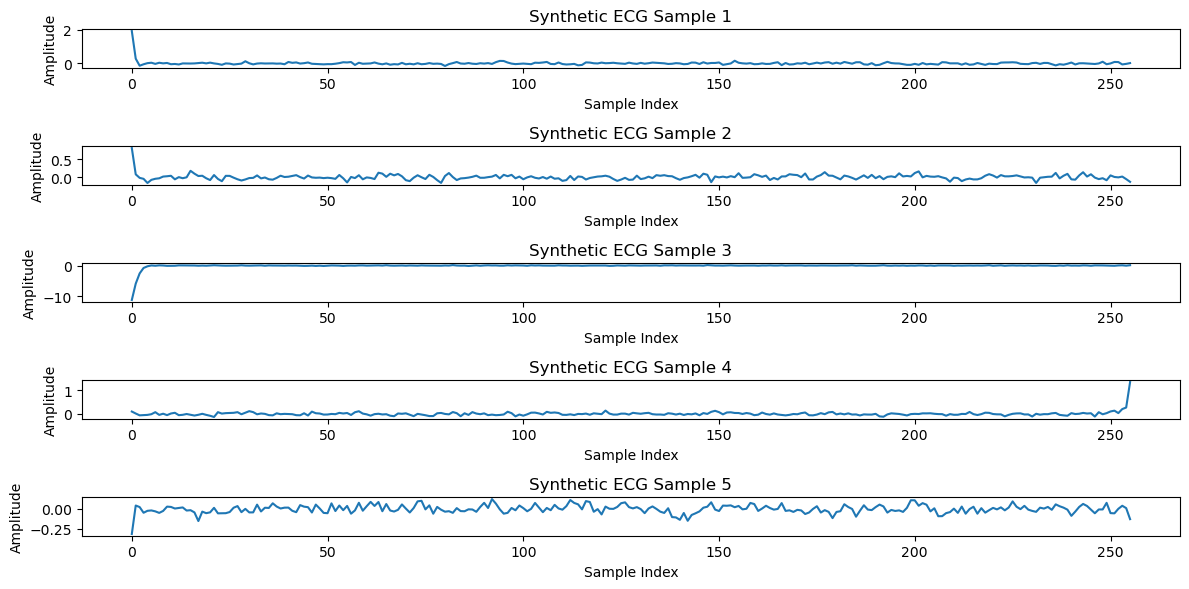

In [11]:
# Generate synthetic ECG signals
synthetic_ecgs = sample_ecg(model, num_samples=5, length=256)

# Plot them
plt.figure(figsize=(12, 6))
for i, ecg in enumerate(synthetic_ecgs):
    plt.subplot(5, 1, i+1)
    plt.plot(ecg)
    plt.title(f"Synthetic ECG Sample {i+1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.tight_layout()

plt.show()